In [1]:
%%bash
gcc main.c -o main.so -fopenmp -lm -O3 -shared -fPIC

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
NUMBER_OF_EXPEREMENTS = 20
MAX_ITERATIONS_COUNT = 1
NET_SIZE = 20000

In [4]:
def get_experiment_result(block_size, threads=8):
    from ctypes import CDLL, Structure, c_size_t, c_double

    so = CDLL("./main.so")

    class exec_res_t(Structure):
        _fields_ = [("number_of_iterations", c_size_t), ("total_time", c_double)]

    so.execute.restype = exec_res_t
    so.set_debug(1)
    so.set_iterations(MAX_ITERATIONS_COUNT)
    so.set_globals(
        c_size_t(threads),
        c_double(-1),
        c_double(-1),
        c_size_t(block_size),
        c_size_t(NET_SIZE),
        c_double(1),
    )
    res = so.execute(5)
    return (res.number_of_iterations, res.total_time)

In [5]:
BLOCK_SIZES = [
    1,  # 1 [0: 11]
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    16,
    32,
    64,
    128,  # 2 [11: 21]
    256,
    300,
    400,
    500,
    600,
    700,
    800,
    900,
    1000,
    2000,
    2730,  # 3 [21:]
    3000,
    4000,
    5000,
    6000,
    7000,
    8000,
    9000,
    10000,
    11000,
    12000,
    13000,
    14000,
]

In [6]:
def get_results(thread):
    results = np.empty((len(BLOCK_SIZES), NUMBER_OF_EXPEREMENTS))

    for exp in range(NUMBER_OF_EXPEREMENTS):
        for i, size in enumerate(BLOCK_SIZES):
            _, time = get_experiment_result(size, thread)
            results[i, exp] = time

    return results

In [7]:
def remove_10_persentile(results):
    # Выкинули 10% измерений как выбросы
    threshold = 0.1
    return np.array(
        [
            sub_array[sub_array < np.percentile(sub_array, 100 - threshold * 100)]
            for sub_array in results
        ]
    )

In [8]:
def get_interval_and_means(filtered):
    def coc(arr):
        # Стандартное отклонение среднего
        std_dev = np.std(arr)
        return std_dev / np.sqrt(arr.size)

    coc_95_lower = [np.mean(sub) - 2 * coc(sub) for sub in filtered]

    means = [np.mean(sub) for sub in filtered]
    coc_95_high = [np.mean(sub) + 2 * coc(sub) for sub in filtered]

    return coc_95_lower, means, coc_95_high

Number of blocks = 19998, blocks/thread = 19998.000000, BLOCK_SIZE = 1
Number of blocks = 9999, blocks/thread = 9999.000000, BLOCK_SIZE = 2
Number of blocks = 6666, blocks/thread = 6666.000000, BLOCK_SIZE = 3
Number of blocks = 5000, blocks/thread = 5000.000000, BLOCK_SIZE = 4
Number of blocks = 4000, blocks/thread = 4000.000000, BLOCK_SIZE = 5
Number of blocks = 3333, blocks/thread = 3333.000000, BLOCK_SIZE = 6
Number of blocks = 2857, blocks/thread = 2857.000000, BLOCK_SIZE = 7
Number of blocks = 2500, blocks/thread = 2500.000000, BLOCK_SIZE = 8
Number of blocks = 1250, blocks/thread = 1250.000000, BLOCK_SIZE = 16
Number of blocks = 625, blocks/thread = 625.000000, BLOCK_SIZE = 32
Number of blocks = 313, blocks/thread = 313.000000, BLOCK_SIZE = 64
Number of blocks = 157, blocks/thread = 157.000000, BLOCK_SIZE = 128
Number of blocks = 79, blocks/thread = 79.000000, BLOCK_SIZE = 256
Number of blocks = 67, blocks/thread = 67.000000, BLOCK_SIZE = 300
Number of blocks = 50, blocks/thread 

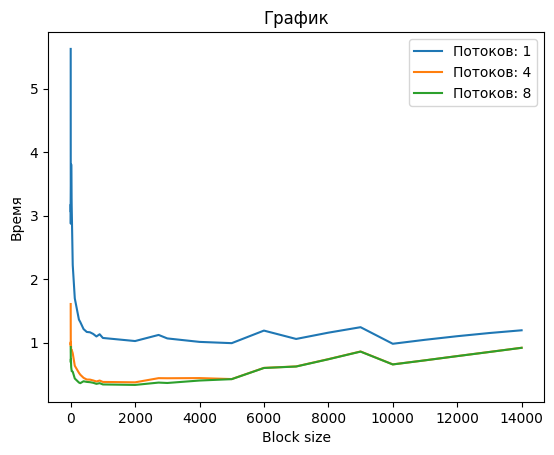

In [9]:
plt.title("График")
plt.xlabel("Block size")
plt.ylabel("Время")

threads = [1, 4, 8]

per_thread_num = [i for i in range(len(threads))]

for i, thread in enumerate(threads):
    res = get_results(thread)
    res = remove_10_persentile(res)
    lower, means, high = get_interval_and_means(res)
    per_thread_num[i] = (lower, means, high)

    plt.plot(BLOCK_SIZES, means, label=f"Потоков: {thread}")
plt.legend()
plt.show()

In [34]:
def show_plot_part(fr=0, to=len(BLOCK_SIZES), excl=()):
    for i, (l, means, h) in enumerate(per_thread_num):
        if threads[i] in excl:
            continue
        plt.plot(BLOCK_SIZES[fr:to], means[fr:to], label=f"Потоков: {threads[i]}")
        plt.legend()

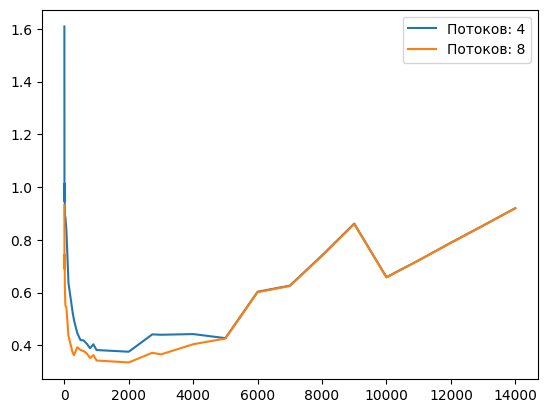

In [37]:
show_plot_part(excl=[1])

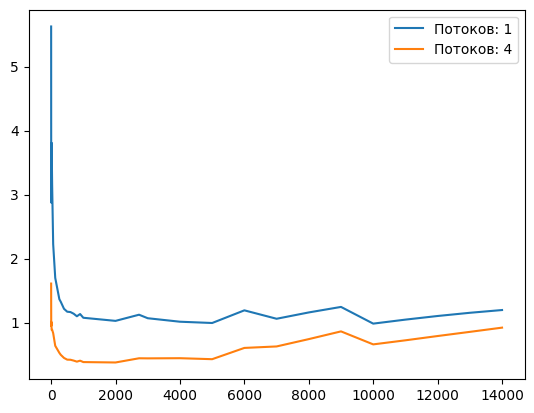

In [39]:
show_plot_part(excl=[8])

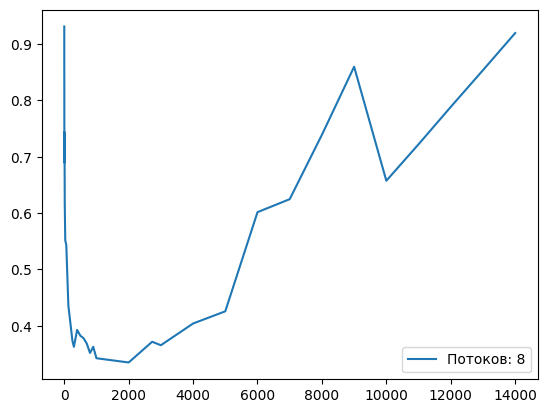

In [38]:
show_plot_part(excl=[1, 4])

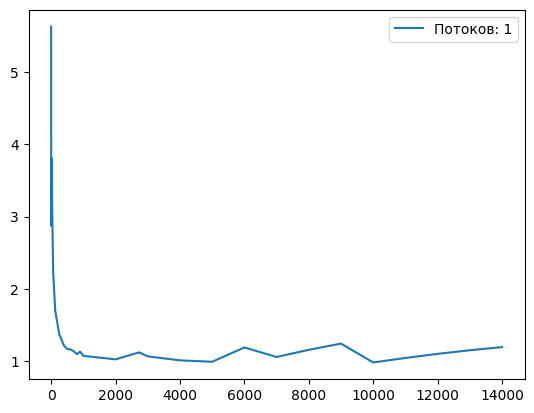

In [40]:
show_plot_part(excl=[4, 8])

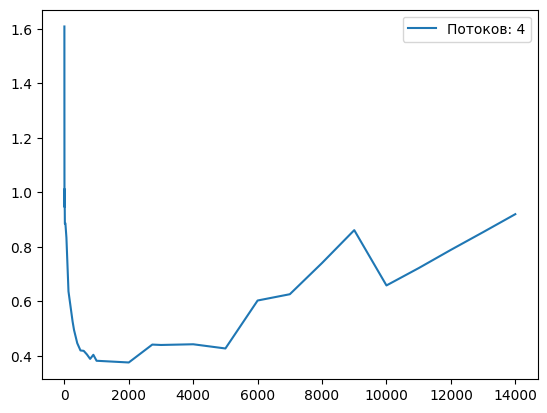

In [41]:
show_plot_part(excl=[1, 8])

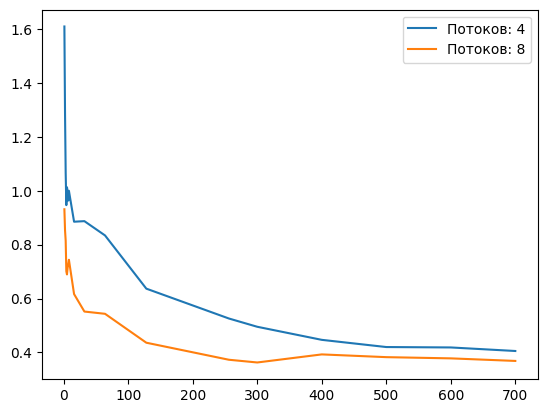

In [45]:
show_plot_part(0, 18, excl=[1])